## Perturbative footprint study

### Imports

In [1]:
# Standard imports
import numpy as np
import shutil
from ruamel.yaml import YAML
import os
import matplotlib.pyplot as plt
import pickle
import subprocess
import time
#from multiprocessing import Pool
#from multiprocessing.dummy import Pool as ThreadPool

# Cern modules
import fillingpatterns as fp
import xtrack as xt

# Improve style
import seaborn as sns

sns.set_theme(style="whitegrid")

### Generate a machine with xmask from the appropriate configuration file

#### First create a proper configuration file

In [2]:
# Copy default configuration file for xmask, and target configuration file for pymask
shutil.copyfile("../modules/xmask/examples/hllhc15_collision/config.yaml", "config_xm.yaml")
shutil.copyfile(
    "/afs/cern.ch/work/c/cdroin/private/DA_study/master_study/opt_flathv_75_1500_withBB_chroma15_1p4_all_bunches/madx_001/config.yaml",
    "config_pm.yaml",
)


# Read and mutate xmask config file
with open("config_xm.yaml", "r") as fid:
    config_xm_str = fid.read()

with open("config_pm.yaml", "r") as fid:
    config_pm_str = fid.read()

yaml = YAML()
config_pm = yaml.load(config_pm_str)
config_xm = yaml.load(config_xm_str)

# Hardcode optics configuration files as they can't be ported directly
config_xm["config_mad"]["links"]["acc-models-lhc"] = "/afs/cern.ch/eng/lhc/optics/HLLHCV1.5"
config_xm["config_mad"]["optics_file"] = "acc-models-lhc/flatcc/opt_flathv_75_180_1500_thin.madx"
config_xm["config_knobs_and_tuning"]["closed_orbit_correction"][
    "lhcb1"
] = "../modules/tools/corr_co_lhcb1.json"
config_xm["config_knobs_and_tuning"]["closed_orbit_correction"][
    "lhcb2"
] = "../modules/tools/corr_co_lhcb2.json"

# Mutate optics and check config
config_xm["config_mad"]["enable_imperfections"] = config_pm["enable_imperfections"]
config_xm["config_mad"]["enable_knob_synthesis"] = config_pm["enable_knob_synthesis"]
config_xm["config_mad"]["ver_hllhc_optics"] = float(config_pm["optics_version"])
config_xm["config_mad"]["pars_for_imperfections"] = config_pm["pars_for_imperfections"]

# Mutate beam config
config_xm["config_mad"]["beam_config"]["lhcb1"]["beam_energy_tot"] = config_pm["beam_energy_tot"]
config_xm["config_mad"]["beam_config"]["lhcb2"]["beam_energy_tot"] = config_pm["beam_energy_tot"]

# Mutate beambeam parameters
config_xm["config_beambeam"]["nemitt_x"] = config_pm["beam_norm_emit_x"] * 1e-6
config_xm["config_beambeam"]["nemitt_y"] = config_pm["beam_norm_emit_y"] * 1e-6
config_xm["config_beambeam"]["sigma_z"] = config_pm["beam_sigt"]
config_xm["config_beambeam"]["num_particles_per_bunch"] = config_pm["beam_npart"]
config_xm["config_beambeam"]["num_particles_per_bunch"] = config_pm["beam_npart"]
for i, ip in enumerate(["ip1", "ip2", "ip5", "ip8"]):
    config_xm["config_beambeam"]["num_long_range_encounters_per_side"][ip] = config_pm[
        "beambeam_config"
    ]["numberOfLRPerIRSide"][i]
config_xm["config_beambeam"]["num_slices_head_on"] = config_pm["beambeam_config"][
    "numberOfHOSlices"
]
config_xm["config_beambeam"]["bunch_spacing_buckets"] = config_pm["beambeam_config"][
    "bunch_spacing_buckets"
]

# Mutate tunes and chromaticities (assume same for both beams, since not settable in pymask)
config_xm["config_knobs_and_tuning"]["qx"]["lhcb1"] = config_pm["qx0"]
config_xm["config_knobs_and_tuning"]["qx"]["lhcb2"] = config_pm["qx0"]
config_xm["config_knobs_and_tuning"]["qy"]["lhcb1"] = config_pm["qy0"]
config_xm["config_knobs_and_tuning"]["qy"]["lhcb2"] = config_pm["qy0"]
config_xm["config_knobs_and_tuning"]["dqx"]["lhcb1"] = config_pm["chromaticity_x"]
config_xm["config_knobs_and_tuning"]["dqx"]["lhcb2"] = config_pm["chromaticity_x"]
config_xm["config_knobs_and_tuning"]["dqy"]["lhcb1"] = config_pm["chromaticity_y"]
config_xm["config_knobs_and_tuning"]["dqy"]["lhcb2"] = config_pm["chromaticity_y"]

# Mutate knobs
for knob in config_pm["knob_settings"]:
    if knob in config_xm["config_knobs_and_tuning"]["knob_settings"]:
        config_xm["config_knobs_and_tuning"]["knob_settings"][knob] = config_pm["knob_settings"][
            knob
        ]
    else:
        print(f"Knob {knob} not found in xmask config file. Beind added now.")
        config_xm["config_knobs_and_tuning"]["knob_settings"][knob] = config_pm["knob_settings"][
            knob
        ]

# Mutate RF voltage and octupole current
config_xm["config_knobs_and_tuning"]["knob_settings"]["vrf400"] = config_pm["vrf_total"]
config_xm["config_knobs_and_tuning"]["knob_settings"]["i_oct_b1"] = config_pm["oct_current"]
config_xm["config_knobs_and_tuning"]["knob_settings"]["i_oct_b2"] = config_pm["oct_current"]


# Artificially implement end of luminosity levelling
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_sep8"] = 0.0
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_sep8h"] = -0.01745641501719127
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_sep8v"] = 0.01371863979152592
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_x8"] = 0.0
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_x8h"] = 0.0
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_x8v"] = 170.0
config_xm["config_knobs_and_tuning"]["knob_settings"]["on_sep2"] = 0.1443593672910653


# ! WARNING. AT THIS POINT:
# ! - Coupling is missing
# ! - bunch-by-bunch and filling schemes are missing


# Write config file
with open("config_xm.yaml", "w") as fid:
    yaml.dump(config_xm, fid)

Knob on_x8h not found in xmask config file. Beind added now.
Knob on_x8v not found in xmask config file. Beind added now.
Knob on_sep8h not found in xmask config file. Beind added now.
Knob on_sep8v not found in xmask config file. Beind added now.


#### Build machine

In [3]:
REBUILD = False
if REBUILD:
    os.system("python build_machine.py")
collider = xt.Multiline.from_json("output/collider_tuned_bb_on.json")
collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


e1efa0c673cc454f98f0137eb1ec5dc4.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from e1efa0c673cc454f98f0137eb1ec5dc4.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


b1d322d818ef423b87e0eaa09cb81783.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from b1d322d818ef423b87e0eaa09cb81783.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Correct bbb schedule

In [4]:
# Get BB schedule
fname = "filling_scheme/8b4e_1972b_1960_1178_1886_224bpi_12inj_800ns_bs200ns.json"
patt = fp.FillingPattern.from_json(fname)

# Compute bb schedule
patt.compute_beam_beam_schedule(n_lr_per_side=25)
bbs_b1 = patt.b1.bb_schedule
bbs_b2 = patt.b2.bb_schedule

# Get list of bunches
bbs_b1

Computing collision schedules...
Done Beam 1
Done Beam 2


,HO partner in ALICE,# of LR in ALICE,BB partners in ALICE,Positions in ALICE,HO partner in ATLAS/CMS,# of LR in ATLAS/CMS,BB partners in ATLAS/CMS,Positions in ATLAS/CMS,HO partner in LHCB,# of LR in LHCB,BB partners in LHCB,Positions in LHCB,collides in ATLAS/CMS,collides in ALICE,collides in LHCB
12,903.0,23,"[879.0, 880.0, 881.0, 882.0, 883.0, 884.0, 885...","[-24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, ...",2682.0,29,"[2657.0, 2658.0, 2659.0, 2660.0, 2661.0, 2662....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",False,True,True
13,904.0,23,"[879.0, 880.0, 881.0, 882.0, 883.0, 884.0, 885...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0,...",2683.0,28,"[2658.0, 2659.0, 2660.0, 2661.0, 2662.0, 2667....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",False,True,True
14,905.0,22,"[880.0, 881.0, 882.0, 883.0, 884.0, 885.0, 886...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0...",2684.0,27,"[2659.0, 2660.0, 2661.0, 2662.0, 2667.0, 2668....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",False,True,True
15,906.0,21,"[881.0, 882.0, 883.0, 884.0, 885.0, 886.0, 891...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9....",2685.0,26,"[2660.0, 2661.0, 2662.0, 2667.0, 2668.0, 2669....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",False,True,True
16,907.0,20,"[882.0, 883.0, 884.0, 885.0, 886.0, 891.0, 892...","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",NaN,12,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[-16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10...",2686.0,25,"[2661.0, 2662.0, 2667.0, 2668.0, 2669.0, 2670....","[-25.0, -24.0, -19.0, -18.0, -17.0, -16.0, -15...",False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,765.0,23,"[741.0, 742.0, 743.0, 744.0, 745.0, 746.0, 747...","[-24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18...",3438.0,21,"[3413.0, 3414.0, 3415.0, 3416.0, 3417.0, 3418....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",2544.0,21,"[2519.0, 2520.0, 2521.0, 2522.0, 2523.0, 2524....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",True,True,True
3439,766.0,23,"[741.0, 742.0, 743.0, 744.0, 745.0, 746.0, 747...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",3439.0,20,"[3414.0, 3415.0, 3416.0, 3417.0, 3418.0, 3423....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",2545.0,20,"[2520.0, 2521.0, 2522.0, 2523.0, 2524.0, 2529....","[-25.0, -24.0, -23.0, -22.0, -21.0, -16.0, -15...",True,True,True
3440,767.0,22,"[742.0, 743.0, 744.0, 745.0, 746.0, 747.0, 748...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",3440.0,19,"[3415.0, 3416.0, 3417.0, 3418.0, 3423.0, 3424....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",2546.0,19,"[2521.0, 2522.0, 2523.0, 2524.0, 2529.0, 2530....","[-25.0, -24.0, -23.0, -22.0, -17.0, -16.0, -15...",True,True,True
3441,768.0,21,"[743.0, 744.0, 745.0, 746.0, 747.0, 748.0, 753...","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -15...",3441.0,18,"[3416.0, 3417.0, 3418.0, 3423.0, 3424.0, 3425....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",2547.0,18,"[2522.0, 2523.0, 2524.0, 2529.0, 2530.0, 2531....","[-25.0, -24.0, -23.0, -18.0, -17.0, -16.0, -15...",True,True,True


In [5]:
def fix_bb_elements(collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False):
    # Reset collider
    if reset_collider:
        for i, x in enumerate(collider.lhcb1.element_names):
            if "bb_lr" in x or "bb_ho" in x:
                try:
                    collider.lhcb1.vars[x + '_scale_strength'] = collider.lhcb1.vars['beambeam_scale']
                    collider.lhcb1.element_refs[x].scale_strength = collider.lhcb1.vars[x + '_scale_strength']
                except Exception as e:
                    print(e)
                    print(f"Failed to reset {x}")
                    
                
        for i, x in enumerate(collider.lhcb2.element_names):
            if "bb_lr" in x or "bb_ho" in x:
                try:
                    collider.lhcb2.vars[x + '_scale_strength'] = collider.lhcb2.vars['beambeam_scale']
                    collider.lhcb2.element_refs[x].scale_strength = collider.lhcb2.vars[x + '_scale_strength']
                except Exception as e:
                    print(e)
                    print(f"Failed to reset {x}")

    # Take care of LR elements
    for ip, name_position in zip(
        [1, 2, 5, 8],
        [
            "Positions in ATLAS/CMS",
            "Positions in ALICE",
            "Positions in ATLAS/CMS",
            "Positions in LHCB",
        ],
    ):
        # Deactivate elements that shouldn't be here in beam 1
        idx_elements_b1 = bbs_b1.loc[bunch_nb][name_position]
        for i, x in enumerate(collider.lhcb1.element_names):
            # print(collider.lhcb1[x].to_dict())
            # First look for bb_elements for current IP
            if "bb_lr.l" + str(ip) in x or "bb_lr.r" + str(ip) in x:
                # Then only keep elements corresponding to the current IP
                pos = int(x.split("_")[2])
                if "l" in x.split("lr.")[1]:
                    pos = -pos
                if pos not in idx_elements_b1:
                    collider.lhcb1.element_refs[x].scale_strength = 0

        # Same with beam 2
        if also_beam_2:
            idx_elements_b2 = bbs_b2.loc[bunch_nb][name_position]
            for i, x in enumerate(collider.lhcb2.element_names):
                if "bb_lr.l" + str(ip) in x or "bb_lr.r" + str(ip) in x:
                    pos = int(x.split("_")[2])
                    if "l" in x.split("lr.")[1]:
                        pos = -pos
                    if pos not in idx_elements_b2:
                        collider.lhcb2.vars[x + '_scale_strength'] = 0

    # Take care of HO elements
    for ip, bool_collide in zip(
        [1, 2, 5, 8],
        ["collides in ATLAS/CMS", "collides in ALICE", "collides in ATLAS/CMS", "collides in LHCB"],
    ):
        collide_b1 = bbs_b1.loc[bunch_nb][bool_collide]

        # Deactivate elements that shouldn't be here in beam 1
        for i, x in enumerate(collider.lhcb1.element_names):
            # First look for bb_elements
            if (
                "bb_ho.l" + str(ip) in x or "bb_ho.r" + str(ip) in x or "bb_ho.c" + str(ip) in x
            ) and not collide_b1:
                collider.lhcb1.element_refs[x].scale_strength = 0

        # Same with beam 2
        if also_beam_2:
            collide_b2 = bbs_b2.loc[bunch_nb][bool_collide]
            for i, x in enumerate(collider.lhcb2.element_names):
                if (
                    "bb_ho.l" + str(ip) in x or "bb_ho.r" + str(ip) in x or "bb_ho.c" + str(ip) in x
                ) and not collide_b2:
                    collider.lhcb2.vars[x + '_scale_strength'] = 0

    # Print final result
    if print_final_result:
        # Beam 1
        print("Beam 1")
        for i, x in enumerate(collider.lhcb1.element_names):
            if "bb_ho" in x or "bb_lr" in x:
                print(x, collider.lhcb1.element_refs[x].scale_strength._value)

        # Beam 2
        if also_beam_2:
            print("Beam 2")
            for i, x in enumerate(collider.lhcb2.element_names):
                if "bb_ho" in x or "bb_lr" in x:
                    print(x, collider.lhcb2.element_refs[x].scale_strength._value)

    # Return collider
    return collider

## Plot footprint for a given bunch

Coupling correction due to the lattice (```delta_cmr``` and ```delta_cmi``` in pymask) are ignored as they're not very relevant for the coupling study.

OK SO FAR
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


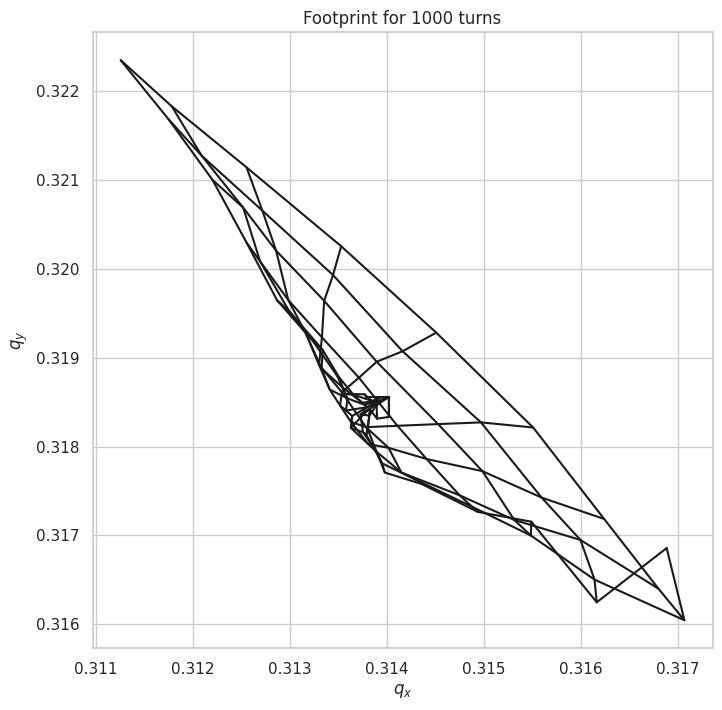

In [6]:
plot_evolution_with_nturns = False
if plot_evolution_with_nturns:
    bunch_nb = 23
    collider = fix_bb_elements(
        collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False
    )

    print('OK SO FAR')
    for n_turns in [100, 500, 1000, 5000, 20000]:
        # Plot footprint
        fp_polar_xm = collider["lhcb1"].get_footprint(
            nemitt_x=2.5e-6,
            nemitt_y=2.5e-6,
            n_turns=n_turns,
            linear_rescale_on_knobs=[
                xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1 / 2)
            ],
        )

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        fp_polar_xm.plot(ax=ax)
        ax.set_title(f"Footprint for {n_turns} turns")
        #plt.show()
        plt.savefig(f"output/footprint_xm_{n_turns}.png")

In [14]:
check_result_without_coupling = False
# Check result without coupling
if check_result_without_coupling:
    # Save values before changing anything
    c_minus_re_b1_before_correction = collider.vars["c_minus_re_b1"]._value
    c_minus_re_b2_before_correction = collider.vars["c_minus_re_b2"]._value
    c_minus_im_b1_before_correction = collider.vars["c_minus_im_b1"]._value
    c_minus_im_b2_before_correction = collider.vars["c_minus_im_b2"]._value

    # Set all couplings to zero
    collider.vars["c_minus_re_b1"] = 0
    collider.vars["c_minus_im_b1"] = 0
    collider.vars["c_minus_re_b2"] = 0
    collider.vars["c_minus_im_b2"] = 0

    # Twiss just to be safe
    collider["lhcb1"].twiss()
    collider["lhcb2"].twiss()

    # Plot footprint
    fp_polar_xm = collider["lhcb1"].get_footprint(
        nemitt_x=2.5e-6,
        nemitt_y=2.5e-6,
        n_turns=2000,
        linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1 / 2)],
    )

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    fp_polar_xm.plot(ax=ax, label="no rescale bb")
    plt.show()

    # Reset values
    collider.vars["c_minus_re_b1"] = c_minus_re_b1_before_correction
    collider.vars["c_minus_im_b1"] = c_minus_im_b1_before_correction
    collider.vars["c_minus_re_b2"] = c_minus_re_b2_before_correction
    collider.vars["c_minus_im_b2"] = c_minus_im_b2_before_correction

### Get footprint for all bunches

In [15]:
def return_footprint(collider, bunch_nb, n_turns):
    # Adapt collider for current bunch
    collider = fix_bb_elements(
        collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False
    )
    # Get footprint
    fp_polar_xm = collider["lhcb1"].get_footprint(
        nemitt_x=2.5e-6,
        nemitt_y=2.5e-6,
        n_turns=n_turns,
        linear_rescale_on_knobs=[
            xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.05)
        ],
    )

    return [fp_polar_xm.qx, fp_polar_xm.qy]

In [16]:
def run_footprint_in_parallel_scripts(collider, l_bunch_nb, n_turns):
    wd = os.getcwd()

    # Build a temporary folder for each bunch number
    for bunch_nb in l_bunch_nb:
        # Ensure you're in workind directory
        os.chdir(wd)

        # Create folder
        folder_name = f"output/{bunch_nb}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Adapt collider
        collider = fix_bb_elements(
            collider, bunch_nb, reset_collider=True, also_beam_2=False, print_final_result=False
        )

        # Save collider as json
        collider.to_json(f"{folder_name}/collider_tuned_bb_on.json")

        # Build a file containing a python script in which I create collider and compute footprint
        with open(f"{folder_name}/footprint.py", "w") as f:
            f.write(f"""
import pickle
import xtrack as xt

# Load collider
collider = xt.Multiline.from_json(f"collider_tuned_bb_on.json")
collider.build_trackers()

# Compute footprint
fp_polar_xm = collider["lhcb1"].get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    n_turns={n_turns},
    linear_rescale_on_knobs=[
        xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.05)
    ],
)

# Save footprint
with open(f"fp_polar_xm.pkl", "wb") as f:
    pickle.dump([fp_polar_xm.qx, fp_polar_xm.qy], f)
            """)
        
        # Move to the folder
        os.chdir(f"{folder_name}/")

        # Run script using subprocess
        subprocess.run(f"python footprint.py &", shell=True)

    # Move back to working directory
    os.chdir(wd)

In [18]:
l_bunch_nb =  list(bbs_b1.index)
n_turns = 2000

# Multiprocessing or multithreading in Python doesn't seem to work :'(
do_multiprocessing_in_notebook = False
do_multiprocessing_in_script = True
if do_multiprocessing_in_notebook:
    pool = Pool(4)
    l_fp = [x for x in pool.starmap(return_footprint, [ (xt.Multiline.from_dict(collider.to_dict()), bunch_nb, n_turns) for bunch_nb in l_bunch_nb[:2]])]

# So I do multiprocessing through scripts
elif do_multiprocessing_in_script:
    size_series = 80
    for series in range(0, len(l_bunch_nb), size_series):
        print(f"Running series {series} to {series+size_series}")
        run_footprint_in_parallel_scripts(collider, l_bunch_nb[series:series+size_series], n_turns)
        # Check every 30 seconds if the last job of the series is done
        while not os.path.exists(f"output/{l_bunch_nb[series+size_series-1]}/fp_polar_xm.pkl"):
            time.sleep(30)



# Running jobs in series is way too slow   
else:
    l_fp = []
    for bunch_nb in l_bunch_nb:
        l_fp.append(return_footprint(collider, bunch_nb, n_turns))

    # Save l_fp
    with open("output/l_fp.pkl", "wb") as f:
        pickle.dump(l_fp, f)


Running series 0 to 20
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           ne from dict: 99%  
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           ne from dict: 94%  
Done loading line from dict.           ne from dict: 97%  
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...
Done loading line from dict.           


1f77bea8547b4d129b006e936b62ba1d.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 


Done loading line from dict.           
Done loading line from dict.           


In file included from 1f77bea8547b4d129b006e936b62ba1d.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
99ba9fc528e54d4a9fbe0ef53112367f.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
41fc65ae37fe46e194dd8aa5fccfe6ec.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
9f39bcfdcbe64b26832e9f0fe2cfa54e.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 99ba9fc528e54d4a9fbe0ef53112367f.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
In file included from 41fc

Done loading line from dict.           
Compiling ContextCpu kernels...


afc2fa86e27f443eb5c5b3eadb10563c.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from afc2fa86e27f443eb5c5b3eadb10563c.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


a0ac83a1d7f5491f9f39c9ee12e7cf14.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from a0ac83a1d7f5491f9f39c9ee12e7cf14.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.Done compiling ContextCpu kernels.

Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done loading line from dict.           
Done compiling ContextCpu kernels.


3dc2edd0e0a44cb698c6761efd5db49e.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 3dc2edd0e0a44cb698c6761efd5db49e.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
bf2d6cb63803405d82a9bacff2d6b6ad.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from bf2d6cb63803405d82a9bacff2d6b6ad.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
efcfca42bcfd4e19af37c925fc7da6c6.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from efcf

Compiling ContextCpu kernels...
Done loading line from dict.           
Compiling ContextCpu kernels...


604c7f026ef44b3b9fac7e9bbed729f7.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 604c7f026ef44b3b9fac7e9bbed729f7.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
a9ad20a3b669422eb1d157e8e83bb2d1.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from a9ad20a3b669422eb1d157e8e83bb2d1.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done loading line from dict.           
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


ace23b5e3d314402b09cc07c80f5ce5f.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from ace23b5e3d314402b09cc07c80f5ce5f.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
d7f76d7ebb2649139f8a023cdb3f7a67.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from d7f76d7ebb2649139f8a023cdb3f7a67.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Loading line from dict:  3%  

0ed8d3c71d9342eb943c1291c79775b2.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 0ed8d3c71d9342eb943c1291c79775b2.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           ne from dict: 85%  
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done loading line from dict.           
Compiling ContextCpu kernels...


54cdeb44761e46d98826c50cf886582f.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 54cdeb44761e46d98826c50cf886582f.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done loading line from dict.           
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


8186abd67f724f67b74ecfdebfe9d292.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 8186abd67f724f67b74ecfdebfe9d292.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


9ad8fc87d74e4f9088f9b40c465f2935.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 9ad8fc87d74e4f9088f9b40c465f2935.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Tracking particles for footprint...
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


817556694ef547a4a15a2f9ed67769bb.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 817556694ef547a4a15a2f9ed67769bb.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Tracking particles for footprint...
Compiling ContextCpu kernels...


370c6ec1290644489196441659b9d411.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 370c6ec1290644489196441659b9d411.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done loading line from dict.           
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


5d5c2690a99f49d8a88d575f883b27d9.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 5d5c2690a99f49d8a88d575f883b27d9.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...


f319432bbf7446d5b8004f3cc069dbe0.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from f319432bbf7446d5b8004f3cc069dbe0.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Tracking particles for footprint...
Compiling ContextCpu kernels...


ba189b4c8bda4936b2d72a45341124bc.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from ba189b4c8bda4936b2d72a45341124bc.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
03263e2451034e6a9675a49f75f6fc2b.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 03263e2451034e6a9675a49f75f6fc2b.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done loading line from dict.           
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


3bfacc5bd855484f830b68a4aa01f1de.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 3bfacc5bd855484f830b68a4aa01f1de.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
16aad066bea24cd9ae4508e63fc2a04f.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 16aad066bea24cd9ae4508e63fc2a04f.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Compiling ContextCpu kernels...
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done loading line from dict.           
Compiling ContextCpu kernels...


dc5d7964327543cd8fa873ceaa56b896.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from dc5d7964327543cd8fa873ceaa56b896.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
c0d211022d7148548ecd79bff3ae4b35.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from c0d211022d7148548ecd79bff3ae4b35.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done loading line from dict.           
Compiling ContextCpu kernels...


12e0bd669316479babd6877a2ac2411f.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 12e0bd669316479babd6877a2ac2411f.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done loading line from dict.           


456ee68b356640389e2e7a2dec9e3c3a.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 456ee68b356640389e2e7a2dec9e3c3a.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Done tracking.rom dict: 35%  
Computing footprint...
Done tracking.rom dict: 55%  
Computing footprint...
Done tracking.rom dict: 57%  
Computing footprint...
Done computing footprint.6%  
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done computing footprint.5%  
Done computing footprint.7%  
Tracking particles for footprint...
Tracking particles for footprint...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done tracking.rom dict: 19%  
Computing footprint...
Done tracking.rom dict: 25%  
Computing footprint...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done computing footprint.4%  
Done computing footprint.1%  
Tracking particles for footprint...


57f75388d4164fd0865f34aa5cc05915.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 57f75388d4164fd0865f34aa5cc05915.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
863d4b2977fc49bdb112f67676f51297.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 863d4b2977fc49bdb112f67676f51297.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Tracking particles for footprint...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done tracking.rom dict: 51%  
Computing footprint...


3b9a2174d3ec498b8a6567eb6c507189.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 3b9a2174d3ec498b8a6567eb6c507189.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done computing footprint.0%  
Tracking particles for footprint...
Running series 20 to 40 83%  


131c176274d4491e8b00024de886ca02.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 131c176274d4491e8b00024de886ca02.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Tracking particles for footprint...
Done loading line from dict.           
Compiling ContextCpu kernels...
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done tracking.rom dict: 49%  
Computing footprint...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done computing footprint.8%  


4669a7cc1b4a4d69b798c7d4f7322f2f.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 4669a7cc1b4a4d69b798c7d4f7322f2f.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
68ffc35e0722436cb0a4d46cbed642af.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 68ffc35e0722436cb0a4d46cbed642af.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Tracking particles for footprint...
Done loading line from dict.           
Done compiling ContextCpu kernels.om dict: 39%  
Done loading line from dict.           
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done tracking.
Computing footprint...
Done compiling ContextCpu kernels.


e7d327fb4d71415b804f9df1e6db2126.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from e7d327fb4d71415b804f9df1e6db2126.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done computing footprint.7%  
Tracking particles for footprint...


1976a4b73aeb4aceb7f8a128ed672ba4.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 1976a4b73aeb4aceb7f8a128ed672ba4.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Compiling ContextCpu kernels...
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


02c7278518b2483f989fc51fc85a8112.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 02c7278518b2483f989fc51fc85a8112.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done loading line from dict.           


ec769e3c373a474885b00625cfbc431e.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from ec769e3c373a474885b00625cfbc431e.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done tracking.rom dict: 90%  
Computing footprint...
Tracking particles for footprint...
Done loading line from dict.           
Done computing footprint.0%  
Tracking particles for footprint...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done loading line from dict.           


b65927094a96481189100cd8ef6c7ad1.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from b65927094a96481189100cd8ef6c7ad1.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
12a36ee6cedc42cdb94d2aadd01489da.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 12a36ee6cedc42cdb94d2aadd01489da.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done tracking.rom dict: 74%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.9%  
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Compiling ContextCpu kernels...
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done tracking.rom dict: 34%  
Computing footprint...
Done tracking.rom dict: 43%  
Computing footprint...
Done tracking.rom dict: 45%  
Computing footprint...
Done computing footprint.4%  
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done computing footprint.3%  
Done computing footprint.5%  


a8a87f363441438da704f7be6f58cf93.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from a8a87f363441438da704f7be6f58cf93.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done tracking.rom dict: 11%  
Computing footprint...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done tracking.rom dict: 39%  
Computing footprint...
Done computing footprint.6%  
Done computing footprint.0%  
Compiling ContextCpu kernels...


8267fc86269f43438356d5ee5b7ff29b.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 8267fc86269f43438356d5ee5b7ff29b.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done tracking.rom dict: 87%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.2%  
Tracking particles for footprint...ct: 28%  
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


7638f47fad0641859b7c77f3fb9535ce.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 7638f47fad0641859b7c77f3fb9535ce.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done tracking.rom dict: 62%  
Computing footprint...
Compiling ContextCpu kernels...


d350e5cb8eb24fc78277900b58e2a494.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from d350e5cb8eb24fc78277900b58e2a494.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done tracking.rom dict: 84%  
Computing footprint...
Done computing footprint.8%  
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done computing footprint.2%  
Tracking particles for footprint...
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


aa17bd053aca4e6eb44bbac1353c8e2e.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from aa17bd053aca4e6eb44bbac1353c8e2e.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done tracking.rom dict: 73%  
Computing footprint...
Compiling ContextCpu kernels...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done computing footprint.5%  


2645f4542f164e24a0fd57ed04f86c00.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 2645f4542f164e24a0fd57ed04f86c00.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Tracking particles for footprint...
Done tracking.rom dict: 47%  ing line from dict: 38%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.1%  
Tracking particles for footprint...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done tracking.rom dict: 41%  
Computing footprint...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


ce04b4ad88654afd833a972f6d759af8.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from ce04b4ad88654afd833a972f6d759af8.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done computing footprint.1%  
Done compiling ContextCpu kernels.


255395f8d13d40a7a5379402c8d736ee.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 255395f8d13d40a7a5379402c8d736ee.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Tracking particles for footprint...
Done loading line from dict.           
Done tracking.rom dict: 57%  ct: 52%  
Computing footprint...
Done computing footprint.9%  
Done loading line from dict.           
Tracking particles for footprint...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


ee302381b9a64236b6e55452fc91c04d.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from ee302381b9a64236b6e55452fc91c04d.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
7abaf14147e74587976122dbc07fd015.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 7abaf14147e74587976122dbc07fd015.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done loading line from dict.           
Compiling ContextCpu kernels...
Done tracking.rom dict: 77%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.6%  
Tracking particles for footprint...
Done loading line from dict.           
Done tracking.rom dict:  5%  
Computing footprint...
Done computing footprint.9%  
Done compiling ContextCpu kernels.
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


e1baa9c2d81f4f4b8e2421e3d3ad130c.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from e1baa9c2d81f4f4b8e2421e3d3ad130c.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Tracking particles for footprint...


88e3e40ef9f84ad2ab739182d7cae2c3.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 88e3e40ef9f84ad2ab739182d7cae2c3.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done compiling ContextCpu kernels.
Done tracking.rom dict: 61%  
Computing footprint...
Compiling ContextCpu kernels...
Done tracking.rom dict: 33%  
Computing footprint...
Done computing footprint.1%  
Done loading line from dict.           
Done computing footprint.7%  
Tracking particles for footprint...
Done loading line from dict.           
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


173f1053899a4237b4d965a9c12381cd.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 173f1053899a4237b4d965a9c12381cd.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...


6712e173ba30497483f4338a6c6449f3.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 6712e173ba30497483f4338a6c6449f3.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Done loading line from dict.           
Compiling ContextCpu kernels...
Done tracking.rom dict: 31%  
Computing footprint...: 77%  
Done compiling ContextCpu kernels.
Done tracking.rom dict: 57%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.6%  
Tracking particles for footprint...
Done computing footprint.8%  
Done loading line from dict.           
Tracking particles for footprint...
Done compiling ContextCpu kernels.
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


d72b4e4ee43747faa9479c401d0b436f.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from d72b4e4ee43747faa9479c401d0b436f.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
be0a701933e2465f842197c8747de722.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from be0a701933e2465f842197c8747de722.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done tracking.rom dict: 83%  
Computing footprint...
Tracking particles for footprint...
Done tracking.rom dict: 86%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.2%  
Done computing footprint.7%  
Tracking particles for footprint...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


28874115b47c4c18b71e0051485a2243.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 28874115b47c4c18b71e0051485a2243.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


cf6f1fb2839d4ccfbc8b7ad9224f70de.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from cf6f1fb2839d4ccfbc8b7ad9224f70de.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done loading line from dict.           
Done tracking.rom dict: 13%  
Computing footprint...
Done computing footprint.3%  
Tracking particles for footprint...
Done loading line from dict.           
Done tracking.rom dict: 80%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.9%  
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done loading line from dict.           


fc9ba4c27df64dbba6b89f7b993c5d11.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from fc9ba4c27df64dbba6b89f7b993c5d11.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done tracking.rom dict: 70%  
Computing footprint...
Tracking particles for footprint...
Done loading line from dict.           
Done computing footprint.5%  


49093217308e4e87bcb25a4bdf3aadbf.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 49093217308e4e87bcb25a4bdf3aadbf.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Tracking particles for footprint...
Done loading line from dict.           
Done tracking.rom dict: 66%  
Computing footprint...
Done computing footprint.7%  
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done loading line from dict.           


aa3d59b78ea9490290f825b03c5aa35b.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from aa3d59b78ea9490290f825b03c5aa35b.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


1752aa418ad24cfda272312b2521e124.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 1752aa418ad24cfda272312b2521e124.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done tracking.rom dict: 14%  
Computing footprint...
Tracking particles for footprint...
Done computing footprint.7%  
Tracking particles for footprint...
Done loading line from dict.           
Done tracking.rom dict: 98%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.2%  
Done compiling ContextCpu kernels.
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


c43239f9d8854ccbb1fc2ea3642138c3.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from c43239f9d8854ccbb1fc2ea3642138c3.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Done tracking.rom dict: 77%  
Computing footprint...
Done loading line from dict.           
Compiling ContextCpu kernels...
Done computing footprint.2%  
Tracking particles for footprint...
Done compiling ContextCpu kernels.


9ed01db1da1c41a78bb8e55ae6490db7.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 9ed01db1da1c41a78bb8e55ae6490db7.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Tracking particles for footprint...
Done tracking.rom dict: 95%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.2%  
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done loading line from dict.           
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


6384bef5cc6d40acbc78bb7171c3670b.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 6384bef5cc6d40acbc78bb7171c3670b.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 
f0ee7fce4e2c4f2eb65b1d00566665e6.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from f0ee7fce4e2c4f2eb65b1d00566665e6.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done loading line from dict.           
Compiling ContextCpu kernels...
Done tracking.rom dict: 69%  
Computing footprint...
Done computing footprint.8%  
Done loading line from dict.           
Done tracking.rom dict: 67%  
Computing footprint...
Tracking particles for footprint...
Done computing footprint.7%  
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done loading line from dict.           
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


2a47b9bec7a249a389254dee2c0c0a07.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 2a47b9bec7a249a389254dee2c0c0a07.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.


89b72c97beb34a1e9834f0ec9d4a48f7.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 89b72c97beb34a1e9834f0ec9d4a48f7.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done tracking.rom dict: 50%  
Computing footprint...
Tracking particles for footprint...
Done computing footprint.7%  
Tracking particles for footprint...
Done loading line from dict.           
Done tracking.rom dict: 68%  
Computing footprint...
Done computing footprint.7%  
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done loading line from dict.           
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


30c2f00246b74aac929018bf20540972.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 30c2f00246b74aac929018bf20540972.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...


aa2e57dc250449d7b4ba4460e8df86d2.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from aa2e57dc250449d7b4ba4460e8df86d2.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Tracking particles for footprint...
Done loading line from dict.           
Done compiling ContextCpu kernels.
Done tracking.rom dict: 19%  
Computing footprint...
Done computing footprint.4%  
Compiling ContextCpu kernels...
Tracking particles for footprint...
Done loading line from dict.           
Done tracking.rom dict: 97%  
Computing footprint...
Done loading line from dict.           
Done computing footprint.0%  
Done compiling ContextCpu kernels.
Done compiling ContextCpu kernels.
Done loading line from dict.           
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...
Compiling ContextCpu kernels...


27550caa59524a06afc1dd1239a7f99c.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 27550caa59524a06afc1dd1239a7f99c.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.


bfe0d6ae07b74904b8d317778473be98.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from bfe0d6ae07b74904b8d317778473be98.c:50:
/afs/cern.ch/work/c/cdroin/private/xmask_DA_study/miniconda/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Compiling ContextCpu kernels...
Done loading line from dict.           


In [2]:
if do_multiprocessing_in_script:
    # Rebuild l_fp
    l_fp = []
    for bunch_nb in l_bunch_nb:
        try:
            with open(f"output/{bunch_nb}/fp_polar_xm.pkl", "rb") as f:
                l_fp.append(pickle.load(f))
        except Exception as e:
            print(f"Error with bunch_nb {bunch_nb}: {e}")
            l_fp.append([np.nan, np.nan])
    
    # Save l_fp
    with open("output/l_fp.pkl", "wb") as f:
        pickle.dump(l_fp, f)

NameError: name 'do_multiprocessing_in_script' is not defined

### Plot all footprints

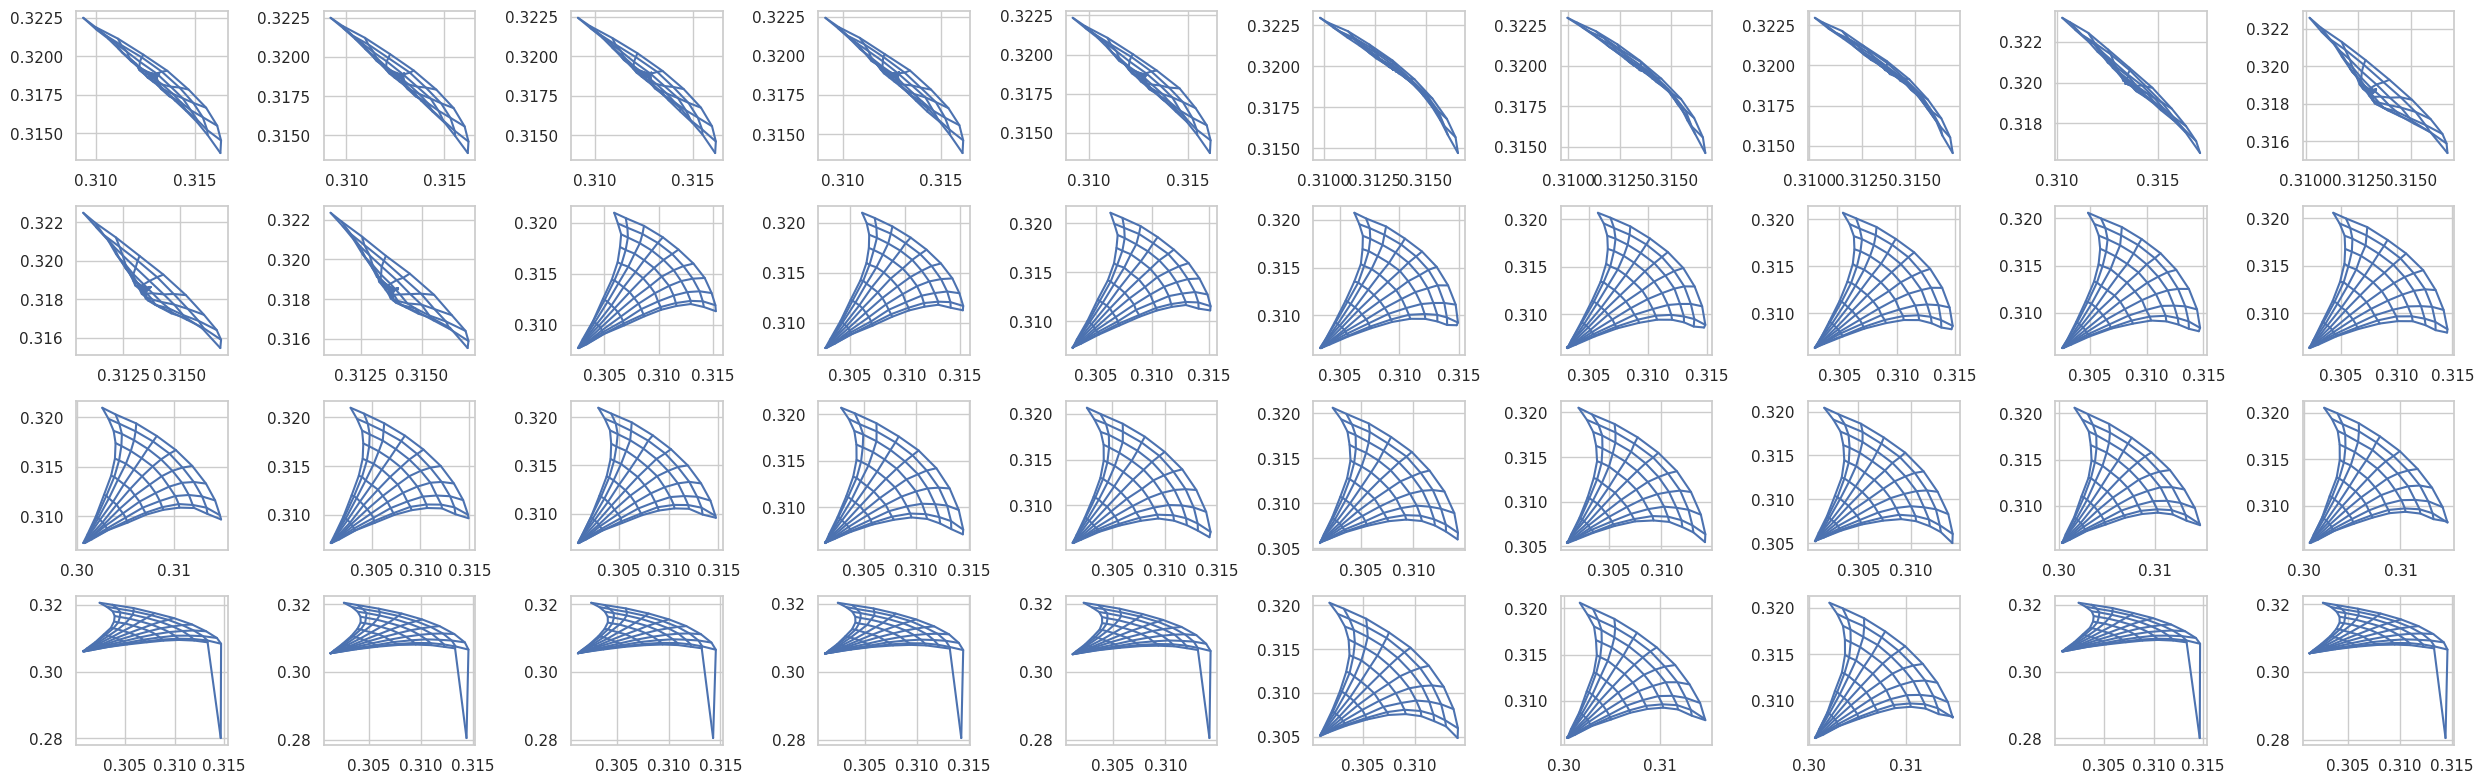

In [7]:
# Load l_fp
with open("output/l_fp.pkl", "rb") as f:
    l_fp = pickle.load(f)

# Make a grid of plots for all the footprints
n_cols = 10
n_rows = int(np.ceil(len(l_fp)/n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
for i, fp in enumerate(l_fp):
    try:
        ax = axs[i//n_cols, i%n_cols]
        ax.plot(fp[0], fp[1], color="C0")
        ax.plot(fp[0].T, fp[1].T, color="C0")
        ax.set_title(f"Bunch {l_bunch_nb[i]}")
        ax.set_xlabel(r"$\mathrm{Q_x}$")
        ax.set_ylabel(r"$\mathrm{Q_y}$")
        #ax.set_xlim(0, 1)
        #ax.set_ylim(0, 1)
        ax.grid()
    except:
        pass

plt.tight_layout()
plt.show()

